# Analysis

Read data files from multiple chillers and create a model

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model    import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model    import RidgeCV
from sklearn.pipeline        import make_pipeline
from sklearn.preprocessing   import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.preprocessing   import StandardScaler
from sklearn.metrics         import mean_squared_error
from sklearn.linear_model    import Lasso
from sklearn                 import linear_model

import seaborn as sns
import matplotlib.pyplot as plt

from math import sqrt

import pickle

%matplotlib inline

import re
import glob


# import custome utility functions
from util import plot_curves
from util import get_Xy
#from util import compute_lift_lines

## LASSO

In [ ]:
'''
ChList = (['1T1','1T2','1T3','1T4','1T5','1T6','1T7','1T8','1T9','1T10','1T11','1T12',
             '5T14','5T16','5T18','5T20',
             'B1','B2','B3','B4',
             'BC1','BC2',
             'C1','C2','C3','C4',
             'S1','S2','S3','S4'])
'''

ChList = (['B1','B2','B3','B4',
             'C1','C2','C3','C4',
             'S1','S2','S3','S4'])

df_all = Plants_to_one_file(ChList)
data_file = 'data/ALL_chillers.csv'
df_all.to_csv(data_file)

#feat = ['HigherOrder','ModelInfo']
feat = ['HigherOrder','ReducedModelInfo','ModelInfoHigherOrder']
#feat = ['HigherOrder']

X, y, df = new_get_Xy(data_file,feat)

print(X.shape)
print(X.dropna().shape)

#divide in to train and test sets
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


In [ ]:
lr_lasso = linear_model.Lasso(alpha=0.1)
lr_fit = lr_lasso.fit(X_train, y_train)

# Print out the R^2 for the model against the full dataset
lr_lasso.score(X_train,y_train)

In [ ]:
#alpha_list = [1e-4, 1e-3, 1e-2, .05, 1e-1,.3,.5,.7]
#alpha_list = [5e-6, 1e-5, 5e-5, 1e-4,5e-4,1e-3]
alpha_list = [1e-5, 5e-5, 1e-4,5e-4]

lasso_results = []
for alpha in alpha_list:
    lr_lasso = linear_model.Lasso(alpha=alpha)
    lr_lasso_fit = lr_lasso.fit(X_train, y_train)

    score = lr_lasso.score(X_train,y_train)
    RMSE = sqrt(mean_squared_error(y_test, lr_lasso.predict(X_test)))
    coef = lr_lasso_fit.coef_.tolist()
    #print(coef)
    lasso_results.append([alpha,score,coef,RMSE])

In [ ]:
X_train.columns

In [ ]:
num_features = X_train.shape[1]

p = 0
num_plots = len(lasso_results)
fig, axes = plt.subplots(nrows=(num_plots+1)//2, ncols=2, figsize=(15, int(num_plots/2)*4))

for alpha,score,coef,RMSE in lasso_results:
    #print(alpha,score,coef)
    test = (alpha == 0.7)
    test = True
    plt.setp(axes, xticks=np.linspace(0,num_features+1, num=num_features+2), 
#             xticklabels=['','Load','DTLift','Load^2','DTLift^2',
#                          'Load*DTLift','Load*DTLift^2','Load^2*DTLift'],
#             ylim=(-.1,.2),
             ylim=(-.001,.001),
             xlim=(0.5,num_features+.5))

    if test:
        axes[p//2,p%2].bar(range(1,num_features+1),coef,
                           label=f"alpha={alpha}, R^2={score:.2g}",
                           color='green',edgecolor='green')
        axes[p//2,p%2].set_xlabel("Feature")
        axes[p//2,p%2].set_ylabel("Lasso Coefficient")
        axes[p//2,p%2].legend()

        p +=1
        
if num_plots%2 == 1:
    axes[num_plots//2, 1].remove()  # don't display empty plot

plt.show()

In [ ]:
X_train.columns

## York Curves

In [ ]:
york

In [ ]:
york = pd.read_csv('data/Chiller_Characteristics/YorkCurves.csv')

X1 = pd.DataFrame()
y1 = pd.DataFrame()
X2 = pd.DataFrame()
y2 = pd.DataFrame()

X1['Load'] = york['Load']
X1['Load^2'] = york['Load']**2
y1['kW/Ton'] = york['YKKJKLH9-CWF']

# Create an empty model
lr = LinearRegression()

# Fit the model to the full dataset
lr.fit(X1, y1)

# Print out the R^2 for the model against the full dataset
print(lr.intercept_)
print(lr.coef_)

X2 = X1.copy()

y2['kW/Ton'] = york['YKPFP4K2-FBG']
lr.fit(X1, y2)
print(lr.intercept_)
print(lr.coef_)


In [ ]:
X1['ModelNo'] = 'YKKJKLH9-CWF'
X2['ModelNo'] = 'YKPFP4K2-FBG'

In [ ]:
ModelCharacteristics = pd.read_csv('data/Chiller_Characteristics/ModelCharacteristics.csv')
X1 = pd.merge(X1, ModelCharacteristics, on='ModelNo')
X2 = pd.merge(X2, ModelCharacteristics, on='ModelNo')


In [ ]:
X = X1.append(X2,sort=False)
y = y1.append(y2,sort=False)

In [ ]:
X = X.dropna(axis=1)
X = X.drop(columns='ModelNo')

In [ ]:
X.columns

In [ ]:
lr_lasso = linear_model.Lasso(alpha=0.1)
lr_fit = lr_lasso.fit(X, y)

# Print out the R^2 for the model against the full dataset
lr_lasso.score(X,y)

In [ ]:
alpha_list = [1e-5, 1e-4,1e-3, 1e-2,1e-1]

lasso_results = []
for alpha in alpha_list:
    lr_lasso = linear_model.Lasso(alpha=alpha)
    lr_lasso_fit = lr_lasso.fit(X, y)

    score = lr_lasso.score(X,y)
    RMSE = sqrt(mean_squared_error(y, lr_lasso.predict(X)))
    coef = lr_lasso_fit.coef_.tolist()
    #print(coef)
    lasso_results.append([alpha,score,coef,RMSE])

In [ ]:
num_features = X.shape[1]

p = 0
num_plots = len(lasso_results)
fig, axes = plt.subplots(nrows=(num_plots+1)//2, ncols=2, figsize=(15, int(num_plots/2)*4))

for alpha,score,coef,RMSE in lasso_results:
    #print(alpha,score,coef)
    test = (alpha == 0.7)
    test = True
    plt.setp(axes, xticks=np.linspace(0,num_features+1, num=num_features+2), 
             ylim=(-.001,.001),
#             xlim=(0.5,num_features+.5)
            )

    if test:
        axes[p//2,p%2].bar(range(1,num_features+1),coef,
                           label=f"alpha={alpha}, R^2={score:.2g}",
                           color='green',edgecolor='green')
        axes[p//2,p%2].set_xlabel("Feature")
        axes[p//2,p%2].set_ylabel("Lasso Coefficient")
        axes[p//2,p%2].legend()

        p +=1
        
if num_plots%2 == 1:
    axes[num_plots//2, 1].remove()  # don't display empty plot

plt.show()

In [ ]:
X_new = X[['Load','Load^2','RatedTons']]
lr.fit(X_new, y)

print(lr.intercept_)
print(lr.coef_)

In [ ]:
X_new = X[['Load','Load^2','RatedTons','CDesFlow']]
lr.fit(X_new, y)

print(lr.intercept_)
print(lr.coef_)

## Functions

In [3]:
def Plants_to_one_file(PlantList):
    PlantToModel = pd.read_csv('data/Chiller_Characteristics/PlantToModel.csv')
    PlantToModel.set_index('Plant',inplace=True)
    ModelCharacteristics = pd.read_csv('data/Chiller_Characteristics/ModelCharacteristics.csv')

    df_all = pd.DataFrame()

    for Plant in PlantList:
        file = 'data/'+Plant+'_chiller.csv'
        foo = re.match('(\d*[A-Z]+)(\d+)',Plant)
        if foo is None:
            raise AttributeError(f'could not match {file}')

        PlantCode = foo.group(1)
        ChCode = foo.group(2)

        print(f'opening file: {file}        plant code: {PlantCode}        chiller code: {ChCode}')

        df = pd.read_csv(file)
        
        ModelNo = PlantToModel.loc[PlantCode+ChCode]['Model']
        df['ModelNo'] = ModelNo
        df['Chiller'] = PlantCode+ChCode

        df = pd.merge(df, ModelCharacteristics, on='ModelNo')
        df_all = df_all.append(df)
    
    return(df_all)

In [4]:
def new_get_Xy(file_name,features=[]):
    df = pd.read_csv(file_name)

    if 'ModelNo' not in df.columns:
        print('getting model info')
        
        foo = re.match('data/(\d*[A-Z]+)(\d+)_chiller.csv',file_name)
        if foo is None:
            raise AttributeError(f'could not match {file_name}')

        PlantCode = foo.group(1)
        ChCode = foo.group(2)

        print(f'opening file: {file_name}        plant code: {PlantCode}        chiller code: {ChCode}')

        PlantToModel = pd.read_csv('data/Chiller_Characteristics/PlantToModel.csv')
        PlantToModel.set_index('Plant',inplace=True)
        ModelCharacteristics = pd.read_csv('data/Chiller_Characteristics/ModelCharacteristics.csv')

        ModelNo = PlantToModel.loc[PlantCode+ChCode]['Model']
        df['ModelNo'] = ModelNo
        df['Chiller'] = PlantCode+ChCode

        df = pd.merge(df, ModelCharacteristics, on='ModelNo')    

    # remove rows with NaN on primary features
    num_rows = df.shape[0]
    df.dropna(subset=['Load','DTLift','kW/Ton'],inplace=True)
    df.reset_index(inplace=True)
    print('DataFrame rows with NaN removed: ',num_rows - df.shape[0])

    y = df['kW/Ton'].copy()
    X = df[['Load','DTLift']].copy()

    if 'HigherOrder' in features:
        X['Load^2']        = df['Load']**2
        X['Load*DTLift']   = df['Load']*df['DTLift']
        X['Load^2*DTLift'] = (df['Load']**2)*df['DTLift']
            
    X = add_features(X, df,features)
    
    print('X with all features',X.shape)

#     if 'ModelInfo' in features:  
#         X['RatedTons']  = df['RatedTons']
#         X['VarSpeed']   = df['VarSpeed']
#         X['RatedkW']    = df['RatedkW']
#         X['CDesFlow']   = df['CDesFlow']
#         X['CPDrop']     = df['CPDrop']
#         X['CEnterTemp'] = df['CEnterTemp']
#         X['CLeaveTemp'] = df['CLeaveTemp']
#         X['EDesFlow']   = df['EDesFlow']
#         X['EPDrop']     = df['EPDrop']
#         X['EEnterTemp'] = df['EEnterTemp']
#         X['ELeaveTemp'] = df['ELeaveTemp']
#     if 'ReducedModelInfo' in features:
#         X['RatedTons']  = df['RatedTons']
#         X['VarSpeed']   = df['VarSpeed']
#         X['CDesFlow']   = df['CDesFlow']
#     if 'ModelInfoHigherOrder' in features:
#         X['RatedTons_Load']          = df['RatedTons']*df['Load']
#         X['RatedTons_DTLift']        = df['RatedTons']*df['DTLift']
#         X['RatedTons_Load^2']        = df['RatedTons']*df['Load']**2
#         X['RatedTons_Load*DTLift']   = df['RatedTons']*df['Load']*df['DTLift']
#         X['RatedTons_Load^2*DTLift'] = df['RatedTons']*df['DTLift']*df['Load']**2
#         X['CDF_Load']          = df['CDesFlow']*df['Load']
#         X['CDF_DTLift']        = df['CDesFlow']*df['DTLift']
#         X['CDF_Load^2']        = df['CDesFlow']*df['Load']**2
#         X['CDF_Load*DTLift']   = df['CDesFlow']*df['Load']*df['DTLift']
#         X['CDF_Load^2*DTLift'] = df['CDesFlow']*df['DTLift']*df['Load']**2

    return X, y, df

In [5]:
def compute_lift_lines(model, features, df, plot=True):
    col_list = ['blue','red','green','gold','purple']
    lift_lines = {}

    if plot:
        plt.figure(figsize=(7,5))
        plt.ylim(0,1)
        plt.xlim(0,1)
        plt.legend()
        plt.xlabel('Load')
        plt.ylabel('xW/Ton')
        plt.grid(True)
    

    X_line = pd.DataFrame()
    for lift in range(10,60,10):
        X_line['Load'] = np.arange(0.2,1,0.8/80)
        X_line['DTLift'] = lift*np.ones(80)
        if 'HigherOrder' in features:
            X_line['Load^2'] = X_line['Load']**2
    #        X_line['DTLift^2'] = X_line['DTLift']**2
            X_line['Load*DTLift'] = X_line['Load']*X_line['DTLift']
    #        X_line['Load*DTLift^2'] = X_line['Load']*X_line['DTLift']**2
            X_line['Load^2*DTLift'] = (X_line['Load']**2)*X_line['DTLift']

        #print(X_line)
        
        X_line = add_features(X_line.copy(),df.copy(),features)
        #print(X_line)
        
#         if 'AddOther' in features:    
#             X_line['CompSH_mean']   = df['CompSH'].mean()
#             X_line['CompSH_std']    = df['CompSH'].std()
#             X_line['CompSH_median'] = df['CompSH'].median()

#             X_line['EvapApproach_mean']   = df['EvapApproach'].mean()
#             X_line['EvapApproach_std']    = df['EvapApproach'].std()
#             X_line['EvapApproach_median'] = df['EvapApproach'].median()

#             X_line['CondApproach_mean']   = df['CondApproach'].mean()
#             X_line['CondApproach_std']    = df['CondApproach'].std()
#             X_line['CondApproach_median'] = df['CondApproach'].median()

#             #X_line['IGV'] = df['IGV']

#             X_line['REFLVL_mean']   = df['REFLVL'].mean()
#             X_line['REFLVL_std']    = df['REFLVL'].std()
#             X_line['REFLVL_median'] = df['REFLVL'].median()
        
#             X_line['RatedTon'] = RatedTon

#         if 'ModelInfo' in features:
#             X_line['RatedTons']  = df['RatedTons'].mean()
#             X_line['VarSpeed']   = df['VarSpeed'].mean()
#             X_line['RatedkW']    = df['RatedkW'].mean()
#             X_line['CDesFlow']   = df['CDesFlow'].mean()
#             X_line['CPDrop']     = df['CPDrop'].mean()
#             X_line['CEnterTemp'] = df['CEnterTemp'].mean()
#             X_line['CLeaveTemp'] = df['CLeaveTemp'].mean()
#             X_line['EDesFlow']   = df['EDesFlow'].mean()
#             X_line['EPDrop']     = df['EPDrop'].mean()
#             X_line['EEnterTemp'] = df['EEnterTemp'].mean()
#             X_line['ELeaveTemp'] = df['ELeaveTemp'].mean()

#         if 'ReducedModelInfo' in features:
#             X_line['RatedTons']  = df['RatedTons'].mean()
#             X_line['VarSpeed']   = df['VarSpeed'].mean()
#             X_line['CDesFlow']   = df['CDesFlow'].mean()
            
#         if 'ModelInfoHigherOrder' in features:
#             X_line['RatedTons_Load']          = df['RatedTons'].mean()*X_line['Load']
#             X_line['RatedTons_DTLift']        = df['RatedTons'].mean()*X_line['DTLift']
#             X_line['RatedTons_Load^2']        = df['RatedTons'].mean()*X_line['Load']**2
#             X_line['RatedTons_Load*DTLift']   = df['RatedTons'].mean()*X_line['Load']*X_line['DTLift']
#             X_line['RatedTons_Load^2*DTLift'] = df['RatedTons'].mean()*X_line['DTLift']*X_line['Load']**2
#             X_line['CDF_Load']          = df['CDesFlow'].mean()*X_line['Load']
#             X_line['CDF_DTLift']        = df['CDesFlow'].mean()*X_line['DTLift']
#             X_line['CDF_Load^2']        = df['CDesFlow'].mean()*X_line['Load']**2
#             X_line['CDF_Load*DTLift']   = df['CDesFlow'].mean()*X_line['Load']*X_line['DTLift']
#             X_line['CDF_Load^2*DTLift'] = df['CDesFlow'].mean()*X_line['DTLift']*X_line['Load']**2

            
#         print('X_line','\n',X_line.tail())
#         print('X_line2','\n',X_line2.tail())
#        print('X with all features',X_line.shape)
        
#        print('captured some NaN in X_line')
#        print(X_line[X_line.isna() == True])
#        X_line.fillna(method='pad',inplace=True)
#        X_line.fillna(method='backfill',inplace=True)

        try:
            y_line = model.predict(X_line)
        except:
            print('failed to compute y_line \n',X_line)
        

        lines = []
        lines.append(X_line['Load'])
        lines.append(y_line)
        lift_lines[lift] = lines
        if plot:
            plt.plot(list(X_line['Load']),y_line,c=col_list[0],label=f'{lift} degrees F Lift')
        col_list.pop(0)

    return lift_lines


In [6]:
def add_features(X, df_in,features):
    if len(X) < len(df_in):
        df = df_in.dropna(subset=['RatedTons'])

        df = df.copy().head(len(X))
    else:
        df = df_in.copy()
    df.reset_index(inplace=True)
#    print('input df',len(df_in),'input X',len(X))
    
    if 'ModelInfo' in features:  
        X['RatedTons']  = df['RatedTons']
        X['VarSpeed']   = df['VarSpeed']
        X['RatedkW']    = df['RatedkW']
        X['CDesFlow']   = df['CDesFlow']
        X['CPDrop']     = df['CPDrop']
        X['CEnterTemp'] = df['CEnterTemp']
        X['CLeaveTemp'] = df['CLeaveTemp']
        X['EDesFlow']   = df['EDesFlow']
        X['EPDrop']     = df['EPDrop']
        X['EEnterTemp'] = df['EEnterTemp']
        X['ELeaveTemp'] = df['ELeaveTemp']
        
    if 'ReducedModelInfo' in features:        
#         df['RatedTons'].fillna(method='pad',inplace=True)
#         df['CDesFlow'].fillna(method='pad',inplace=True)
#         df['VarSpeed'].fillna(method='pad',inplace=True)
    
        X['RatedTons']  = df['RatedTons']
        X['VarSpeed']   = df['VarSpeed']
        X['CDesFlow']   = df['CDesFlow']
                
#        X['RatedTons'].fillna(method='pad',inplace=True)
#        X['CDesFlow'].fillna(method='pad',inplace=True)
#        X['VarSpeed'].fillna(method='pad',inplace=True)

    if 'ModelInfoHigherOrder' in features:
#        df['RatedTons'].fillna(method='pad',inplace=True)
#        df['CDesFlow'].fillna(method='pad',inplace=True)

        X['RatedTons_Load']          = df['RatedTons']*X['Load']
#        X['RatedTons_DTLift']        = df['RatedTons']*X['DTLift']
        X['RatedTons_Load^2']        = df['RatedTons']*X['Load^2']
#        X['RatedTons_Load*DTLift']   = df['RatedTons']*X['Load*DTLift']
#        X['RatedTons_Load^2*DTLift'] = df['RatedTons']*X['Load^2*DTLift']
        X['CDF_Load']          = df['CDesFlow']*X['Load']
#        X['CDF_DTLift']        = df['CDesFlow']*X['DTLift']
        X['CDF_Load^2']        = df['CDesFlow']*X['Load^2']
#        X['CDF_Load*DTLift']   = df['CDesFlow']*X['Load*DTLift']
#        X['CDF_Load^2*DTLift'] = df['CDesFlow']*X['Load^2*DTLift']

        X['CPD_Load']          = df['CPDrop']*X['Load']
        X['CPD_Load^2']        = df['CPDrop']*X['Load^2']

        X['EDF_Load']          = df['EDesFlow']*X['Load']
        X['EDF_Load^2']        = df['EDesFlow']*X['Load^2']

        X['EDP_Load']          = df['EPDrop']*X['Load']
        X['EDP_Load^2']        = df['EPDrop']*X['Load^2']
        
#        EAstd = df_in['EvapApproach'].std()
#        X['EA_Load']          = EAstd*X['Load']
#        X['EA_DTLift']        = EAstd*X['DTLift']
#        X['EA_Load^2']        = EAstd*X['Load^2']
#        X['EA_Load*DTLift']   = EAstd*X['Load*DTLift']
#        X['EA_Load^2*DTLift'] = EAstd*X['Load^2*DTLift']
        
    return X

In [16]:
def Ch_Results(Chiller,feat,lr):

    data_file = 'data/'+Chiller+'_chiller.csv'
    X_test, y_test, df = new_get_Xy(data_file,feat)
    print(Chiller+':',X_train.shape,y_train.shape)
    print('R^2: ',lr.score(X_test,y_test))
    
    lift_lines = compute_lift_lines(lr, feat, df, plot=False)
    plot_curves(df,lift_lines,'Chiller '+Chiller)



In [8]:
def pltcolor(lift,col_list):
    cols=[]
    for l in lift:
        if l <= 15:
            cols.append(col_list[10])
        elif (l > 15) and (l <= 25):
            cols.append(col_list[20])
        elif (l > 25) and (l <= 35):
            cols.append(col_list[30])
        elif (l > 35) and (l <= 45):
            cols.append(col_list[40])
        elif (l > 45):
            cols.append(col_list[50])
    return cols

def plot_all_curves(ChList,feat,model,savefile=''):
    
    num_plots = len(ChList)
    fig, axes = plt.subplots(nrows=(num_plots+1)//2, ncols=2, figsize=(15, int(num_plots/2)*7))

    col_list = { 10:'blue',
                 20:'red',
                 30:'green',
                 40:'gold',
                 50:'purple'
               }
    p = 0
    for Chiller in ChList:
        
        plt.setp(axes, ylim=(0,1), xlim=(0,1))

        data_file = 'data/'+Chiller+'_chiller.csv'
        X_test, y_test, df = new_get_Xy(data_file,feat)
        RMSE = sqrt(mean_squared_error(y_test, model.predict(X_test)))

        R2 = model.score(X_test,y_test)
        
        print(f'Chiller {Chiller}: RMSE={RMSE}, R2={R2}')
        
        lift_lines = compute_lift_lines(model, feat, df, plot=False)
        
        pickle.dump(lift_lines,open(Chiller+'lift_lines.pkl','wb'))
        
        for key in lift_lines:
            x_line = lift_lines[key][0]
            y_line = lift_lines[key][1]

            axes[p//2,p%2].plot(x_line,y_line,c='white',linewidth=3.0)            
            axes[p//2,p%2].plot(x_line,y_line,c=col_list[key],linewidth=1.0,label=f'{key} degrees F Lift')
            
        # call function to set the bands of colors
        bands = pltcolor(list(df['DTLift']),col_list)
        
        axes[p//2,p%2].scatter(x=df['Load'],y=df['kW/Ton'],s=2,c=bands,label='')
 
        axes[p//2,p%2].set_xlabel("Load")
        axes[p//2,p%2].set_ylabel("kW/Ton")
        axes[p//2,p%2].legend()
        axes[p//2,p%2].set_title(f'{Chiller} with R^2={R2:.2g}')
        
        if (Chiller == 'B1') or (Chiller == 'B2') or (Chiller == 'B3'):
            york = pd.read_csv('data/Chiller_Characteristics/YorkCurves.csv')
            axes[p//2,p%2].plot(york['Load']/100.,york['YKKJKLH9-CWF'],c='black',marker='o',linewidth=2.0) 

        elif (Chiller == 'S1') or (Chiller == 'S2') or (Chiller == 'S3') or (Chiller == 'S4'):
            york = pd.read_csv('data/Chiller_Characteristics/YorkCurves.csv')
            axes[p//2,p%2].plot(york['Load']/100.,york['YKPFP4K2-FBG'],c='black',marker='o',linewidth=2.0)            
            
        p +=1
        
    if num_plots%2 == 1:
        axes[num_plots//2, 1].remove()  # don't display empty plot

    if savefile != '':
#        fig = plt.figure()
        fig.savefig(savefile)

    plt.show()


## test multiple plants, plot in subplots

In [9]:
#'''
ChList = (['1T1','1T2','1T3','1T4','1T5','1T7','1T8','1T9','1T10','1T11','1T12',
             '5T1','5T2','5T3','5T4',
             'B1','B2','B3','B4',
             'BC1','BC2',
             'C1','C2','C3','C4',
             'S1','S2','S3','S4'])
#'''

#ChList = (['S1','S2','S3'])

#ChList = (['BB1'])
#ChList = (['B1','B2','B3','B4',
#             'C1','C2','C3','C4',
#             'S1','S2','S3','S4'])


df_all = Plants_to_one_file(ChList)
data_file = 'data/ALL_chillers.csv'
df_all.to_csv(data_file)

opening file: data/1T1_chiller.csv        plant code: 1T        chiller code: 1
opening file: data/1T2_chiller.csv        plant code: 1T        chiller code: 2
opening file: data/1T3_chiller.csv        plant code: 1T        chiller code: 3
opening file: data/1T4_chiller.csv        plant code: 1T        chiller code: 4
opening file: data/1T5_chiller.csv        plant code: 1T        chiller code: 5
opening file: data/1T7_chiller.csv        plant code: 1T        chiller code: 7
opening file: data/1T8_chiller.csv        plant code: 1T        chiller code: 8
opening file: data/1T9_chiller.csv        plant code: 1T        chiller code: 9
opening file: data/1T10_chiller.csv        plant code: 1T        chiller code: 10
opening file: data/1T11_chiller.csv        plant code: 1T        chiller code: 11
opening file: data/1T12_chiller.csv        plant code: 1T        chiller code: 12
opening file: data/5T1_chiller.csv        plant code: 5T        chiller code: 1
opening file: data/5T2_chiller.csv

In [19]:
#feat = ['HigherOrder','ModelInfo']
feat = ['HigherOrder','ReducedModelInfo','ModelInfoHigherOrder']
#feat = ['HigherOrder','ReducedModelInfo']
#feat = ['HigherOrder']

X, y, df = new_get_Xy(data_file,feat)

print(X.shape)
#print(X.dropna().shape)

#divide in to train and test sets
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# Create an empty model
lr = LinearRegression()

pickle.dump(lr,open('lr.pkl','wb'))

# Fit the model to the full dataset
lr.fit(X_train, y_train)

# Print out the R^2 for the model against the full dataset
print(lr.intercept_)
print(lr.coef_)

DataFrame rows with NaN removed:  35600
X with all features (923837, 18)
(923837, 18)
(554302, 18) (554302,)
(369535, 18) (369535,)
-0.17038186517022968
[ 9.78091348e-01  2.24682087e-02 -9.74678303e-01 -2.14522597e-02
  5.81758684e-03  2.76057631e-03  4.16507507e-02 -8.32798423e-04
 -9.55293822e-03  1.28751273e-02  2.78988956e-03 -3.70757285e-03
 -3.44496984e-02  4.67064221e-02 -3.35531007e-04  2.32341657e-04
  6.28069223e-02 -9.05106548e-02]


In [11]:
print('train: ',lr.score(X_train,y_train))
print('test : ',lr.score(X_test,y_test))

train:  0.9145685053875051
test :  0.9154626796038481


getting model info
opening file: data/1T1_chiller.csv        plant code: 1T        chiller code: 1
DataFrame rows with NaN removed:  3
X with all features (52990, 18)
Chiller 1T1: RMSE=0.025758672348366752, R2=0.7210125397074642
getting model info
opening file: data/1T2_chiller.csv        plant code: 1T        chiller code: 2
DataFrame rows with NaN removed:  0
X with all features (37681, 18)
Chiller 1T2: RMSE=0.04317408329637933, R2=0.2294851447431021
getting model info
opening file: data/1T3_chiller.csv        plant code: 1T        chiller code: 3
DataFrame rows with NaN removed:  0
X with all features (8224, 18)
Chiller 1T3: RMSE=0.041635772286064174, R2=0.10645758634737645
getting model info
opening file: data/1T4_chiller.csv        plant code: 1T        chiller code: 4
DataFrame rows with NaN removed:  0
X with all features (18766, 18)
Chiller 1T4: RMSE=0.09361233985540345, R2=-6.852237149289996
getting model info
opening file: data/1T5_chiller.csv        plant code: 1T        chi

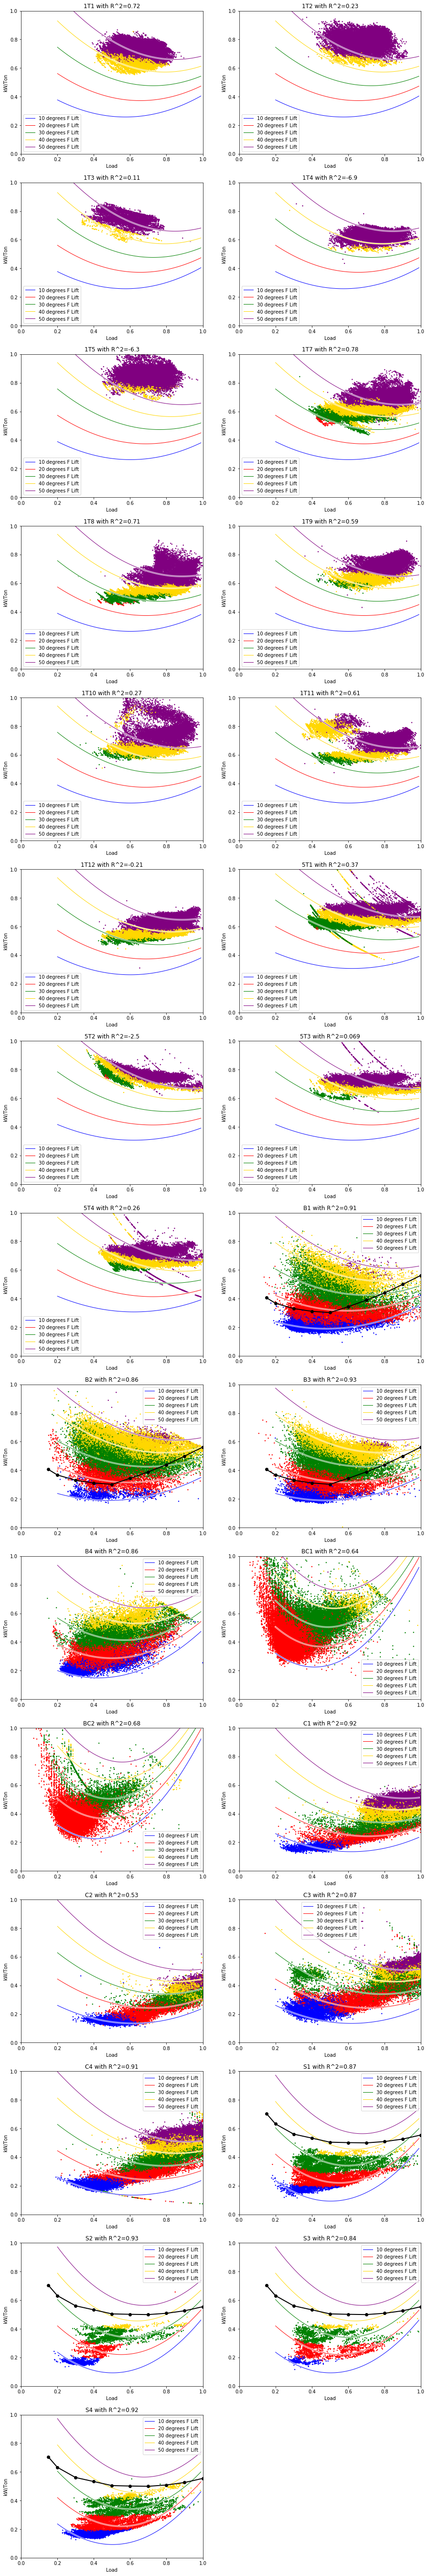

In [12]:
#savefile = '1T_5T_BC_B_C_S.pdf'
savefile = ''
plot_all_curves(ChList,feat,lr,savefile)

In [ ]:
#ChList = (['B1','B2','B3'])

#plot_all_curves(ChList,feat,lr)

## BCBS

In [17]:
feat = ['HigherOrder','ModelInfo']
RatedTon = 900
    
PlantCode = 'B'
Chillers = ['1','2','3','4']

for c in Chillers:
    Ch_Results(PlantCode+c,feat,lr)


getting model info
opening file: data/B1_chiller.csv        plant code: B        chiller code: 1
DataFrame rows with NaN removed:  132
X with all features (32881, 16)
B1: (554302, 18) (554302,)


ValueError: shapes (32881,16) and (18,) not aligned: 16 (dim 1) != 18 (dim 0)

## Things to try

Random Forest Regression